In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as PipelineBalance

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')

y = train['Survived']
X = train.drop('Survived', axis=1)

In [3]:
for column in X.columns:
    print(f"{column} Tipo: {X[column].dtype}, Nº de nulos: {np.sum(X[column].isnull())}, valores únicos: {len(set(X[column]))}")

PassengerId Tipo: int64, Nº de nulos: 0, valores únicos: 891
Pclass Tipo: int64, Nº de nulos: 0, valores únicos: 3
Name Tipo: object, Nº de nulos: 0, valores únicos: 891
Sex Tipo: object, Nº de nulos: 0, valores únicos: 2
Age Tipo: float64, Nº de nulos: 177, valores únicos: 265
SibSp Tipo: int64, Nº de nulos: 0, valores únicos: 7
Parch Tipo: int64, Nº de nulos: 0, valores únicos: 7
Ticket Tipo: object, Nº de nulos: 0, valores únicos: 681
Fare Tipo: float64, Nº de nulos: 0, valores únicos: 248
Cabin Tipo: object, Nº de nulos: 687, valores únicos: 148
Embarked Tipo: object, Nº de nulos: 2, valores únicos: 4


In [4]:
class Tratamento(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunas_numericas = X.select_dtypes('number').columns
        self.colunas_categoricas = X.select_dtypes('object').columns
        return self
    def transform(self, X, y=None):
        remover = ['PassengerId', 'Name', 'Ticket', 'Cabin']
        X = X.drop(remover, axis=1)
        return X

In [5]:
class AtributosNumericos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunas_numericas = X.select_dtypes('number').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunas_numericas]

In [6]:
class AtributosCategoricos(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.colunas_categoricas = X.select_dtypes('object').columns
        return self
    def transform(self, X, y=None):
        return X[self.colunas_categoricas]

In [7]:
pipenum = Pipeline([
    ('numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [8]:
pipecat = Pipeline([
    ('categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
])

In [9]:
unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat),
])

In [10]:
steps = [
    ('tratamento', Tratamento()),
    ('preproc', unecaracteristicas),
    ('sampler', SMOTE(random_state=42)),
    ('clf', SVC())
]
params = {
    'preproc__pipenum__imputer__strategy': ['median', 'most_frequent'],
    'preproc__pipenum__scaler__with_mean': [True, False],
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

pipeline = PipelineBalance(steps)

modelo = GridSearchCV(pipeline, param_grid=params, verbose=1)
scores = cross_validate(modelo, X, y, error_score='raise')
scores, np.mean(scores['test_score'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


({'fit_time': array([4.61975574, 4.40977693, 5.25193191, 4.35509443, 4.43244576]),
  'score_time': array([0.01079178, 0.01064682, 0.01065826, 0.01034117, 0.01052189]),
  'test_score': array([0.79329609, 0.82022472, 0.81460674, 0.81460674, 0.85955056])},
 0.8204569706860838)

In [11]:
modelo.fit(X, y)
modelo.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Pipeline(steps=[('tratamento', Tratamento()),
                ('preproc',
                 FeatureUnion(transformer_list=[('pipenum',
                                                 Pipeline(steps=[('numericos',
                                                                  AtributosNumericos()),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))])),
                                                ('pipecat',
                                                 Pipeline(steps=[('categoricos',
                                                                  AtributosCategoricos()),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('encoder',
                                                                  OneHotEncoder())]))])),
                ('sampler', SMOTE(random_state=42)), ('clf', SVC())])

In [12]:
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
ypred = modelo.predict(test)
submission['Survived'] = ypred
submission.to_csv('submission_svm_smote.csv', index=False)

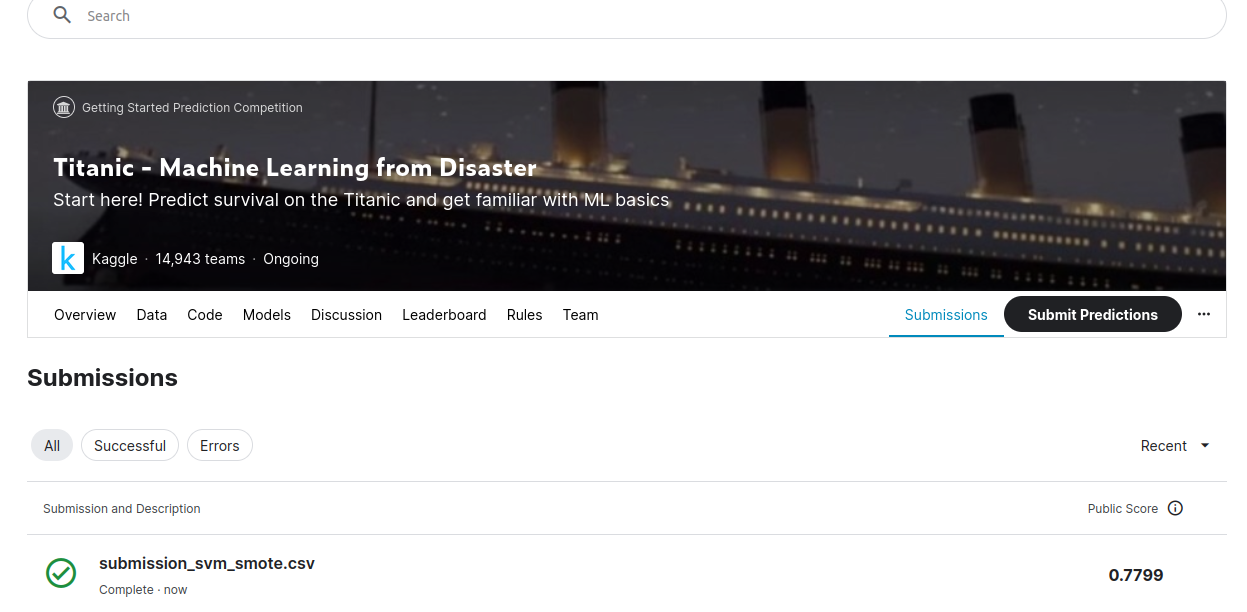